After looking at the visualization here, I believe the countries belong to certain categories but I didn't know how to define the profile of those categories. Still using the same data, I try clustering technique utilizing K-means algorithm.

## Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

In [2]:
#import dataset
df = pd.read_csv('data/Birthrate_Deathrate_fsi_pop_gdp.csv')
df_2019 = df[(df['Region'].notnull()) & (df['Year'] == 2019) & (df['IncomeGroup'].notnull()) & (df['BirthRate'].notnull()) & (df['DeathRate'].notnull()) 
             & (df['Total'].notnull())]

In [3]:
#change IncomeGroup to integer and store the encoded IncomeGroup to IncomeGroup_enc
le = LabelEncoder()
df_2019['IncomeGroup_enc'] = le.fit_transform(df_2019['IncomeGroup'])

#adding derived feature
df_2019['NC'] = df_2019['BirthRate']-df_2019['DeathRate']
df_2019.head()

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,CountryName,CountryCode,Year,BirthRate,DeathRate,CountryName_fsi,CountryName_wb,Region,IncomeGroup,Country,...,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention,Population,GDP,IncomeGroup_enc,NC
28,El Salvador,SLV,2019,18.054,7.070,El Salvador,El Salvador,Latin America & Caribbean,Lower middle income,El Salvador,...,4.2,5.8,5.7,7.0,4.8,5.3,6453550.0,2.689666e+10,2,10.984
88,Equatorial Guinea,GNQ,2019,32.783,9.112,Equatorial Guinea,Equatorial Guinea,Sub-Saharan Africa,Upper middle income,Equatorial Guinea,...,9.8,8.1,8.6,7.9,4.5,4.4,1355982.0,1.141728e+10,3,23.671
148,Eritrea,ERI,2019,29.738,7.012,Eritrea,Eritrea,Sub-Saharan Africa,Low income,Eritrea,...,9.4,7.8,8.7,8.4,7.7,7.0,NaN,NaN,1,22.726
208,Estonia,EST,2019,10.600,11.600,Estonia,Estonia,Europe & Central Asia,High income,Estonia,...,2.1,2.3,1.7,2.2,2.5,3.7,1326898.0,3.104559e+10,0,-1.000
268,Ethiopia,ETH,2019,31.896,6.418,Ethiopia,Ethiopia,Sub-Saharan Africa,Low income,Ethiopia,...,8.0,8.3,8.2,9.0,8.7,7.9,112078727.0,9.591259e+10,1,25.478


In [4]:
le.fit(df_2019['IncomeGroup'])
le_name_mapping = pd.DataFrame(le.classes_, le.transform(le.classes_))
le_name_mapping['Income Group'] = le_name_mapping.index
le_name_mapping = le_name_mapping.rename(columns={le_name_mapping.columns[0]: "IncomeGroup" })

le_name_mapping

,IncomeGroup,Income Group
0,High income,0
1,Low income,1
2,Lower middle income,2
3,Upper middle income,3


Since the analysis is the continuation of the following data storytelling, I want to be consistent with the story so only three measures are analyzed, Natural Change, Fragile State Index(FSI), and Income Group

In [5]:
#select columns for the analysis
df_2019_withname = df_2019[['CountryName','CountryCode','NC','IncomeGroup','IncomeGroup_enc','Total']]
df_clust = df_2019[['NC','IncomeGroup_enc','Total']]

In [6]:
cols_scale = df_clust.columns
df_clust.head()

,NC,IncomeGroup_enc,Total
28,10.984,2,69.8
88,23.671,3,82.6
148,22.726,1,96.4
208,-1.000,0,40.8
268,25.478,1,94.2


## Clustering Process

In [7]:
#Scaling
scaler = MinMaxScaler().fit(df_clust[cols_scale])
df_clust[cols_scale] = scaler.transform(df_clust[cols_scale]);
df_clust.head()

C:\Users\Lily\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lily\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,NC,IncomeGroup_enc,Total
28,0.399151,0.666667,0.547619
88,0.685514,1.000000,0.680124
148,0.664184,0.333333,0.822981
208,0.128657,0.000000,0.247412
268,0.726300,0.333333,0.800207


To determine the number of category, I use charts below and look for the elbow with lowest inertia, then choose the one with the highest silhouette coefficients. The number of cluster chosen will be used in K-means algorithm.

In [8]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(df_clust)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [9]:
kmeans_kwargs = {"init": "k-means++",
                  "n_init": 10,
                  "max_iter": 300,
                  "random_state": 42}

In [10]:
   # A list holds the SSE values for each k, to plot in elbow plot
   sse = []
   for k in range(1, 11):
       kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
       kmeans.fit(df_clust)
       sse.append(kmeans.inertia_)
    
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_clust)
    score = silhouette_score(df_clust, kmeans.labels_)
    silhouette_coefficients.append(score)

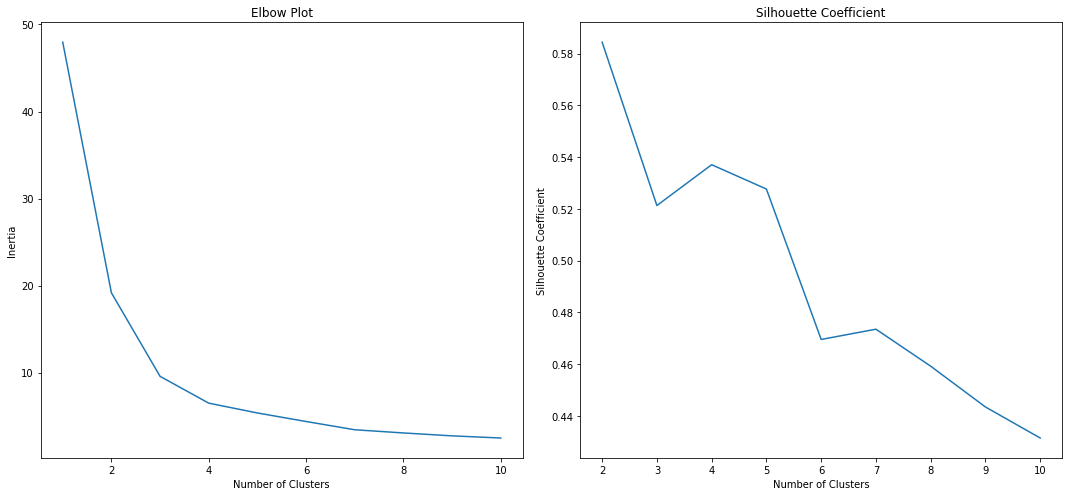

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.tight_layout(pad=7)
axes[0].plot(range(1, 11), sse)
axes[0].set(title='Elbow Plot', xlabel='Number of Clusters', 
       ylabel='Inertia')
axes[1].plot(range(2, 11), silhouette_coefficients)
axes[1].set(title='Silhouette Coefficient', xlabel='Number of Clusters', 
       ylabel='Silhouette Coefficient')
fig.tight_layout()

In [12]:
kmeans_1 = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++',random_state=42)
kmeans_1.fit(df_clust)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [13]:
df_2019kmeans_result = df_2019_withname.copy()
df_2019kmeans_result['cluster_ids'] = kmeans_1.labels_

## Result

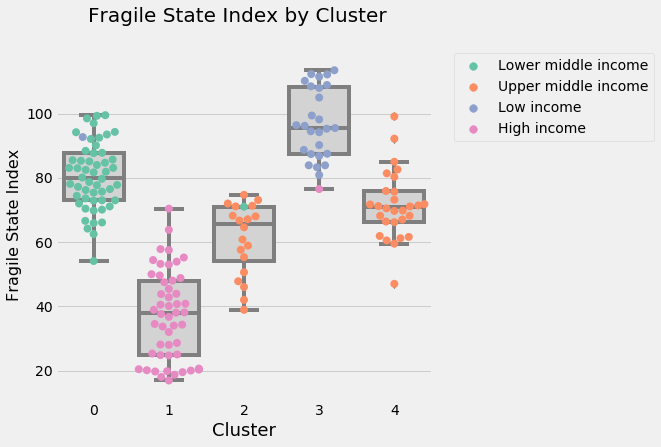

In [14]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="cluster_ids", y="Total", data=df_2019kmeans_result, color="lightgrey")
ax = sns.swarmplot(x="cluster_ids", y="Total", data=df_2019kmeans_result, hue="IncomeGroup",palette="Set2",size = 8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.suptitle('Fragile State Index by Cluster', fontsize=20)
plt.xlabel('Cluster', fontsize=18)
plt.ylabel('Fragile State Index', fontsize=16)
plt.show()

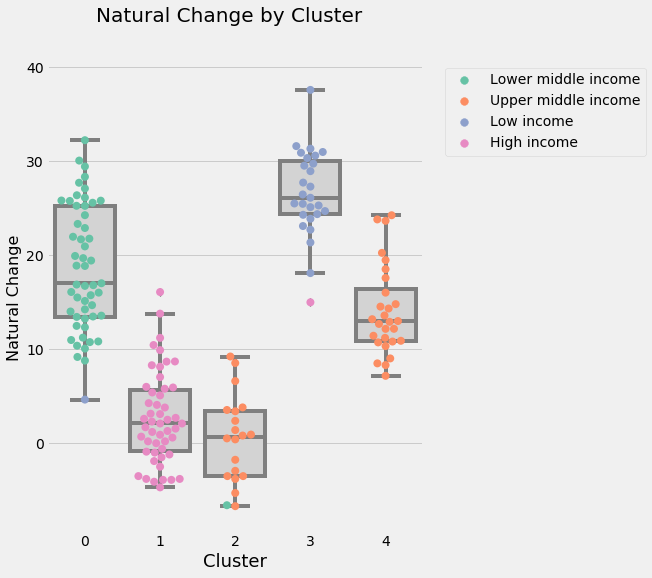

In [15]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 8))

az = sns.boxplot(x="cluster_ids", y="NC", data=df_2019kmeans_result,color="lightgrey")
az = sns.swarmplot(x="cluster_ids", y="NC", data=df_2019kmeans_result, hue="IncomeGroup", palette="Set2",size = 8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.suptitle('Natural Change by Cluster', fontsize=20)
plt.xlabel('Cluster', fontsize=18)
plt.ylabel('Natural Change', fontsize=16)
plt.show()

Income category provided by World Bank differentiate countries quite well. Using clusters created by K-means clustering method, the result isn't too far off from World Bank's. The countries are in the same category except for Upper Middle Income. K-means separated Upper Middle Income into two clusters; one with low Natural Change and lower Fragile State Index and one with both higher Natural Change and Fragile State Index. Table below shows the profile of each cluster.

In [16]:
df_clust_Income = pd.DataFrame(df_2019kmeans_result.groupby('cluster_ids')['IncomeGroup_enc'].mean().round(0).astype(int))
#print(df_clust_Income)
#print(le_name_mapping)
df_clust_mapping = pd.merge(df_clust_Income, le_name_mapping, how='left',left_on = 'IncomeGroup_enc',right_on = 'Income Group')
#print(df_clust_mapping)
df_clust_mapping = df_clust_mapping[['IncomeGroup','Income Group']]
df_clust_mapping = df_clust_mapping.T.reset_index()
df_clust_mapping = df_clust_mapping.rename(columns={'index':'Indicator'})
new_col = ['mean', 'Income Group']
df_clust_mapping.insert(loc=1, column='Metric', value=new_col)

In [17]:
df_clust_sum1 = df_2019kmeans_result.groupby('cluster_ids').describe().round(2).T.reset_index()
df_clust_sum1 = df_clust_sum1.rename(columns={'level_0':'Indicator','level_1':'Metric'})
df_clust_sum1.loc[df_clust_sum1['Indicator'] == 'NC', 'Indicator'] = 'Natural Change'
df_clust_sum1.loc[df_clust_sum1['Indicator'] == 'Total', 'Indicator'] = 'Fragile State Index'
df_clust_sum1.loc[df_clust_sum1['Indicator'] == 'IncomeGroup_enc', 'Indicator'] = 'Income Group'
df_clust_sum1 = pd.concat([df_clust_sum1, df_clust_mapping], axis=0)
df_clust_sum1

cluster_ids,Indicator,Metric,0,1,2,3,4
0,Natural Change,count,53,50,20,27,28
1,Natural Change,mean,18.67,2.69,0.37,26.61,14.13
2,Natural Change,std,6.59,4.86,4.67,4.61,4.74
3,Natural Change,min,4.64,-4.7,-6.7,15,7.17
4,Natural Change,25%,13.48,-0.83,-3.5,24.35,10.88
5,Natural Change,50%,17.03,2.1,0.66,26.13,12.96
6,Natural Change,75%,25.26,5.7,3.43,30.05,16.42
7,Natural Change,max,32.25,16.09,9.23,37.6,24.26
8,Income Group,count,53,50,20,27,28
9,Income Group,mean,1.98,0,2.95,0.96,3
